# DX 704 Week 9 Project

This week's project will build an email spam classifier based on the Enron email data set.
You will perform your own feature extraction, and use naive Bayes to estimate the probability that a particular email is spam or not.
Finally, you will review the tradeoffs from different thresholds for automatically sending emails to the junk folder.

The full project description and a template notebook are available on GitHub: [Project 9 Materials](https://github.com/bu-cds-dx704/dx704-project-09).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Download Data Set

We will be using the Enron spam data set as prepared in this GitHub repository.

https://github.com/MWiechmann/enron_spam_data

You may need to download this differently depending on your environment.

In [3]:
!wget https://github.com/MWiechmann/enron_spam_data/raw/refs/heads/master/enron_spam_data.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import pandas as pd

In [2]:
# pandas can read the zip file directly
enron_spam_data = pd.read_csv("enron_spam_data.zip")
enron_spam_data

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


In [3]:
(enron_spam_data["Spam/Ham"] == "spam").mean()

np.float64(0.5092834262664611)

## Part 2: Design a Feature Extractor

Design a feature extractor for this data set and write out two files of features based on the text.
Don't forget that both the Subject and Message columns are relevant sources of text data.
For each email, you should count the number of repetitions of each feature present.
The auto-grader will assume that you are using a multinomial distribution in the following problems.

In [8]:
# Design Feature extractor for the subject and message fields
from sklearn.feature_extraction.text import CountVectorizer
import json

# Combine Subject and Message into a single text field
enron_spam_data['combined_text'] = (
    enron_spam_data['Subject'].fillna('') + ' ' + enron_spam_data['Message'].fillna('')
)

# Configure CountVectorizer with good spam detection parameters
vectorizer = CountVectorizer(
    lowercase=True,           # Normalize case
    ngram_range=(1, 1),       # Use unigrams
    stop_words=None           # Keep stop words
)

# Fit and transform on the combined text
feature_matrix = vectorizer.fit_transform(enron_spam_data['combined_text'])
feature_names = vectorizer.get_feature_names_out()

print(f"Extracted {len(feature_names)} features")
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Sample features: {list(feature_names[-20:])}")

Extracted 158285 features
Feature matrix shape: (33716, 158285)
Sample features: ['þpor', 'þque', 'þquieres', 'þqué', 'þse', 'þte', 'þtiene', 'þtus', 'þtý', 'þu', 'þya', 'þá', 'þãõ', 'þåè', 'þí', 'þîñõþàà', 'þô', 'þöyledir', 'þù', 'þúíâí']


Assign a row to the test data set if `Message ID % 30 == 0` and assign it to the training data set otherwise.
Write two files, "train-features.tsv" and "test-features.tsv" with two columns, Message ID and features_json.
The features_json column should contain a JSON dictionary where the keys are your feature names and the values are integer feature values.
This will give us a sparse feature representation.


In [9]:
# Split data: test if Message ID % 30 == 0, otherwise train
train_mask = enron_spam_data['Message ID'] % 30 != 0
test_mask = enron_spam_data['Message ID'] % 30 == 0

train_data = enron_spam_data[train_mask].copy()
test_data = enron_spam_data[test_mask].copy()

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Convert feature matrix to sparse JSON format
def create_features_json(feature_matrix, feature_names):
    """Convert scipy sparse matrix to list of JSON dictionaries with non-zero counts"""
    features_list = []
    
    for i in range(feature_matrix.shape[0]):
        # Get non-zero features for this row
        row = feature_matrix[i]
        non_zero_indices = row.nonzero()[1]
        
        # Create dictionary with feature names and counts
        feature_dict = {
            feature_names[idx]: int(row[0, idx])
            for idx in non_zero_indices
        }
        
        features_list.append(json.dumps(feature_dict))
    
    return features_list

# Get feature indices for train and test splits
train_indices = train_data.index
test_indices = test_data.index

# Create features JSON for train and test
train_features_json = create_features_json(feature_matrix[train_indices], feature_names)
test_features_json = create_features_json(feature_matrix[test_indices], feature_names)

# Create DataFrames with Message ID and features_json
train_output = pd.DataFrame({
    'Message ID': train_data['Message ID'].values,
    'features_json': train_features_json
})

test_output = pd.DataFrame({
    'Message ID': test_data['Message ID'].values,
    'features_json': test_features_json
})

# Save to TSV files
train_output.to_csv('train-features.tsv', sep='\t', index=False)
test_output.to_csv('test-features.tsv', sep='\t', index=False)


Training samples: 32592
Test samples: 1124


In [10]:
print("\nSample train features:")
print(train_output.head(3))
print(f"\nSample feature JSON: {train_features_json[0][:200]}...")

print("\nSample test features:")
print(test_output.head(3))
print(f"\nSample feature JSON: {test_features_json[0][:200]}...")


Sample train features:
   Message ID                                      features_json
0           1  {"vastar": 6, "resources": 4, "inc": 4, "gary"...
1           2  {"nomination": 2, "gas": 2, "calpine": 2, "dai...
2           3  {"from": 3, "on": 4, "at": 1, "10": 3, "for": ...

Sample feature JSON: {"vastar": 6, "resources": 4, "inc": 4, "gary": 2, "production": 3, "from": 3, "the": 8, "high": 2, "island": 2, "larger": 2, "block": 2, "commenced": 1, "on": 7, "saturday": 1, "at": 3, "00": 2, "abo...

Sample test features:
   Message ID                                      features_json
0           0  {"christmas": 1, "tree": 1, "farm": 1, "pictur...
1          30  {"christmas": 1, "production": 3, "from": 1, "...
2          60  {"the": 1, "of": 1, "by": 1, "please": 1, "cal...

Sample feature JSON: {"christmas": 1, "tree": 1, "farm": 1, "pictures": 1}...


Submit "train-features.tsv" and "test-features.tsv" in Gradescope.

Hint: these features will be graded based on the test accuracy of a logistic regression based on the training features.
This is to make sure that your feature set is not degenerate; you do not need to compute this regression yourself.
You can separately assess your feature quality based on your results in part 6.

## Part 3: Compute Conditional Probabilities

Based on your training data, compute appropriate conditional probabilities for use with naïve Bayes.
Use of additive smoothing with $\alpha=1$ to avoid zeros.


In [ ]:
# compute appropriate probabilities for features given ham/spam classes
import numpy as np

feature_probs = np.zeros((2, len(feature_names)))
cumsum = train_features_json.cumsum(axis=0)



Top 10 conditional probability features:
the: Spam:0.0309 and Ham:0.0409
to: Spam:0.0237 and Ham:0.0291
and: Spam:0.0211 and Ham:0.0188
of: Spam:0.0202 and Ham:0.0174
you: Spam:0.0135 and Ham:0.0077
in: Spam:0.0131 and Ham:0.0136
this: Spam:0.0099 and Ham:0.0065
for: Spam:0.0098 and Ham:0.0112
your: Spam:0.0096 and Ham:0.0030
is: Spam:0.0095 and Ham:0.0086


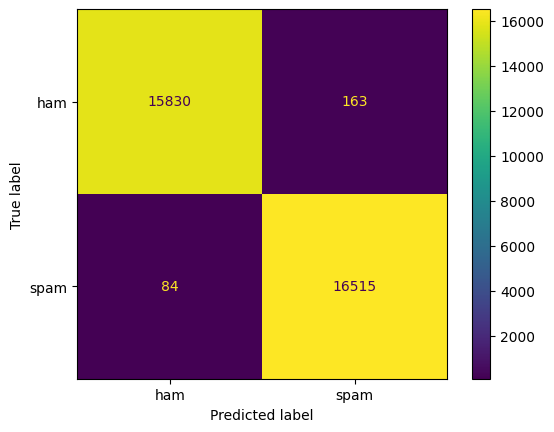

In [ ]:
# Train a bayesian model on the training data
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

model_mnb = MultinomialNB(alpha=1.0)
model_mnb.fit(feature_matrix[train_indices], train_data['Spam/Ham'])

# Evaluate the model
train_pred = model_mnb.predict(feature_matrix[train_indices])
cm = confusion_matrix(train_data['Spam/Ham'], train_pred)
ConfusionMatrixDisplay(cm, display_labels=model_mnb.classes_).plot()

# Compute the conditional probabilities of each feature
feature_log_probs = model_mnb.feature_log_prob_
feature_probs = np.exp(feature_log_probs)

# Display the top 10 conditional probability features
spam_class_index = list(model_mnb.classes_).index('spam')
ham_class_index = list(model_mnb.classes_).index('ham')
spam_feature_probs = feature_probs[spam_class_index]
ham_feature_probs = feature_probs[ham_class_index]
top_spam_indices = np.argsort(spam_feature_probs)[-10:][::-1]
print("Top 10 conditional probability features:")
for idx in top_spam_indices:
    print(f"{feature_names[idx]}: Spam:{spam_feature_probs[idx]:.4f} and Ham:{ham_feature_probs[idx]:.4f}")

Save the conditional probabilities in a file "feature-probabilities.tsv" with columns feature, ham_probability and spam_probability.

In [21]:
# Save the conditional probabilities to a TSV file
import pandas as pd

feature_prob_df = pd.DataFrame({
    'feature': feature_names,
    'ham_probability': ham_feature_probs,
    'spam_probability': spam_feature_probs
})

feature_prob_df

,feature,ham_probability,spam_probability
0,00,1.544494e-03,1.735535e-03
1,000,1.064690e-03,1.564451e-03
2,0000,6.943628e-06,1.452159e-04
3,000000,1.388726e-06,4.468181e-05
4,00000000,1.388726e-06,2.939593e-07
...,...,...,...
158280,þîñõþàà,2.314543e-07,5.879185e-07
158281,þô,2.314543e-07,5.879185e-07
158282,þöyledir,2.314543e-07,8.818778e-07
158283,þù,2.314543e-07,2.057715e-06


In [23]:
feature_prob_df.to_csv('submission/feature_probabilities.tsv', sep='\t', index=False)

Submit "feature-probabilities.tsv" in Gradescope.

## Part 4: Implement a Naïve Bayes Classifier

Implement a naïve Bayes classifier based on your previous feature probabilities.

In [ ]:
# Implement a niave

...

Save your prediction probabilities to "train-predictions.tsv" with columns Message ID, ham and spam.

In [ ]:
# YOUR CHANGES HERE

...

Submit "train-predictions.tsv" in Gradescope.

## Part 5: Predict Spam Probability for Test Data

Use your previous classifier to predict spam probability for the test data.

In [ ]:
# YOUR CHANGES HERE

...

Save your prediction probabilities in "test-predictions.tsv" with the same columns as "train-predictions.tsv".

In [ ]:
# YOUR CHANGES HERE

...

Submit "test-predictions.tsv" in Gradescope.

## Part 6: Construct ROC Curve

For every probability threshold from 0.01 to .99 in increments of 0.01, compute the false and true positive rates from the test data using the spam class for positives.
That is, if the predicted spam probability is greater than or equal to the threshold, predict spam.

In [ ]:
# YOUR CHANGES HERE

...

Save this data in a file "roc.tsv" with columns threshold, false_positive_rate and true_positive rate.

In [ ]:
# YOUR CHANGES HERE

...

Submit "roc.tsv" in Gradescope.

## Part 7: Signup for Gemini API Key

Create a free Gemini API key at https://aistudio.google.com/app/api-keys.
You will need to do this with a personal Google account - it will not work with your BU Google account.
This will not incur any charges unless you configure billing information for the key.

You will be asked to start a Gemini free trial for week 11.
This will not incur any charges unless you exceed expected usage by an order of magnitude.


No submission needed.

## Part 8: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

## Part 9: Acknowledgements

If you discussed this assignment with anyone, please acknowledge them here.
If you did this assignment completely on your own, simply write none below.

If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for. If you did not use any other libraries, simply write none below.

If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy. If you did not use any generative AI tools, simply write none below.